<ipython-input-2-747381be5e56>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[numerical_cols] = df_cleaned[numerical_cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce'))


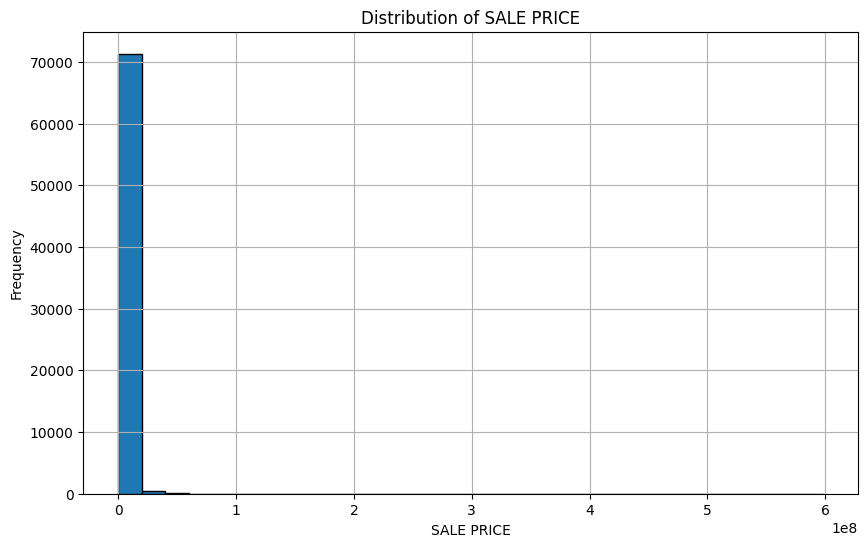

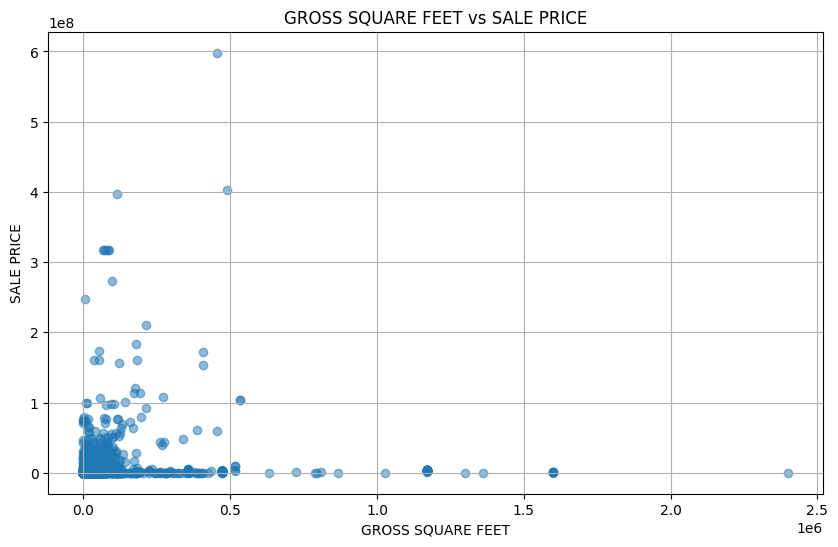

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Baseline Linear Regression - MAE: 1220872.68
Baseline Linear Regression - RMSE: 7550324.91
Baseline Linear Regression - R2: 0.07
XGBoost - MAE: 1112774.29
XGBoost - RMSE: 7552392.61
XGBoost - R2: 0.07


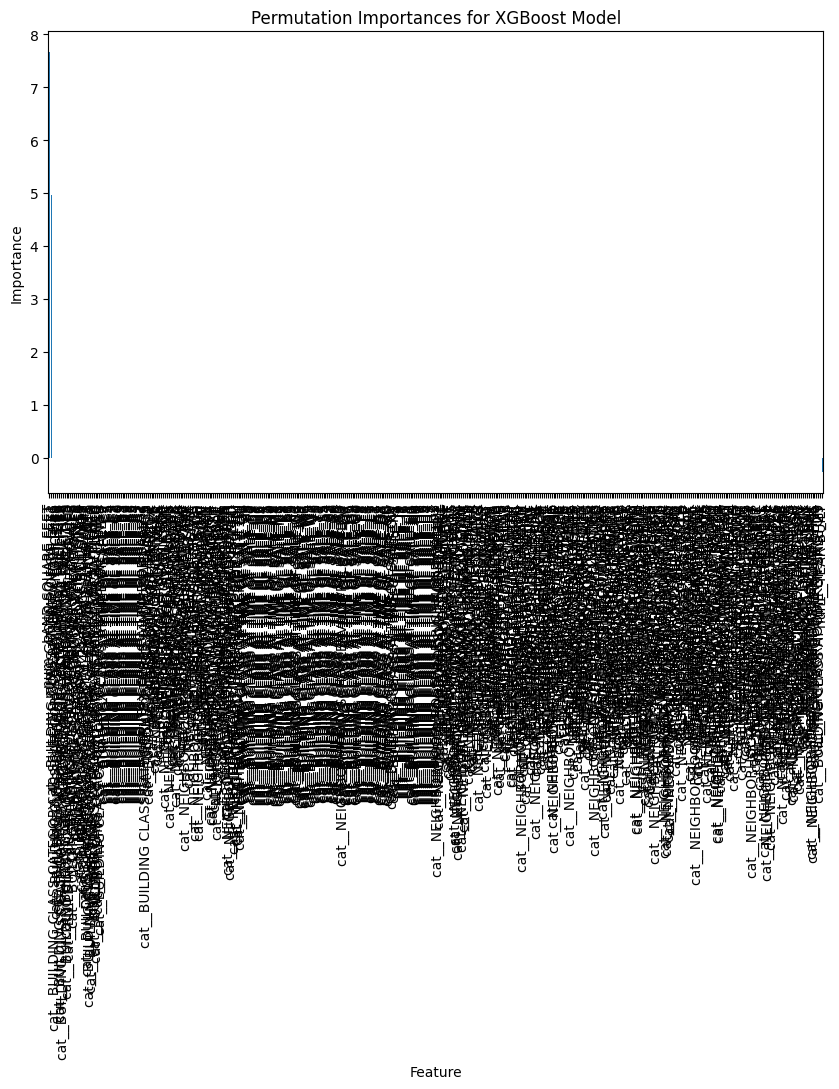

['final_xgb_model.pkl']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import numpy as np
import joblib

# Load the dataset
data_path = "/content/NYC_Citywide_Rolling_Calendar_Sales_20240513.csv"
df = pd.read_csv(data_path)

# Drop rows with missing values in relevant columns
relevant_cols = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE',
                 'BUILDING CLASS AT TIME OF SALE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET',
                 'YEAR BUILT', 'SALE PRICE']
df_cleaned = df.dropna(subset=relevant_cols)

# Remove commas and non-numeric characters from numerical columns
numerical_cols = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']
df_cleaned[numerical_cols] = df_cleaned[numerical_cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce'))

# Define categorical and numerical columns
categorical_cols = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE']

# Pipeline for preprocessing numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for preprocessing categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine the preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data into features (X) and target variable (y)
X = df_cleaned.drop('SALE PRICE', axis=1)
y = df_cleaned['SALE PRICE']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit the preprocessing pipeline to the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Exploratory Visualizations
# Plot the distribution of 'SALE PRICE'
plt.figure(figsize=(10, 6))
plt.hist(df['SALE PRICE'], bins=30, edgecolor='black')
plt.xlabel('SALE PRICE')
plt.ylabel('Frequency')
plt.title('Distribution of SALE PRICE')
plt.grid(True)
plt.show()

# Scatter plot for 'GROSS SQUARE FEET' vs 'SALE PRICE'
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['GROSS SQUARE FEET'], df_cleaned['SALE PRICE'], alpha=0.5)
plt.xlabel('GROSS SQUARE FEET')
plt.ylabel('SALE PRICE')
plt.title('GROSS SQUARE FEET vs SALE PRICE')
plt.grid(True)
plt.show()

# Fit a baseline Linear Regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train_processed, y_train)

# Preprocess the test data and make predictions
X_test_processed = preprocessor.transform(X_test)
y_pred_baseline = baseline_model.predict(X_test_processed)

# Evaluate the Linear Regression model using regression metrics
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = mean_squared_error(y_test, y_pred_baseline, squared=False)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline Linear Regression - MAE: {mae_baseline:.2f}")
print(f"Baseline Linear Regression - RMSE: {rmse_baseline:.2f}")
print(f"Baseline Linear Regression - R2: {r2_baseline:.2f}")

# Try XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_processed, y_train)

# Make predictions with XGBoost
y_pred_xgb = xgb_model.predict(X_test_processed)

# Evaluate the XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MAE: {mae_xgb:.2f}")
print(f"XGBoost - RMSE: {rmse_xgb:.2f}")
print(f"XGBoost - R2: {r2_xgb:.2f}")

# Convert sparse matrix to dense
X_test_dense = X_test_processed.toarray()

# Get permutation importances for the XGBoost model
perm_importance = permutation_importance(xgb_model, X_test_dense, y_test, n_repeats=10, random_state=42)

# Display permutation importances
perm_importances = pd.Series(perm_importance.importances_mean, index=preprocessor.get_feature_names_out())
perm_importances.sort_values(ascending=False, inplace=True)

# Plot permutation importances
plt.figure(figsize=(10, 6))
perm_importances.plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Importances for XGBoost Model')
plt.show()

# Save the final XGBoost model to disk
joblib.dump(xgb_model, 'final_xgb_model.pkl')

In [7]:
!pip install shap pdpbox

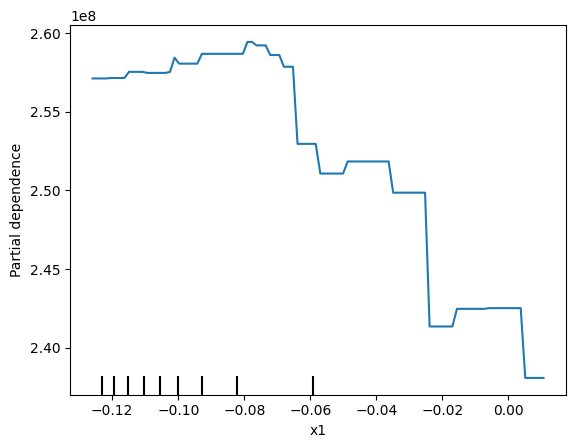

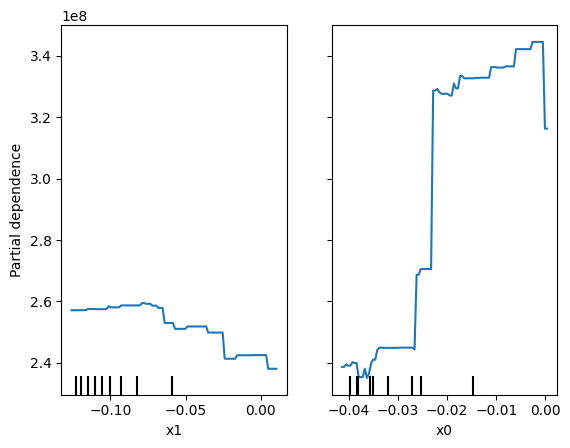

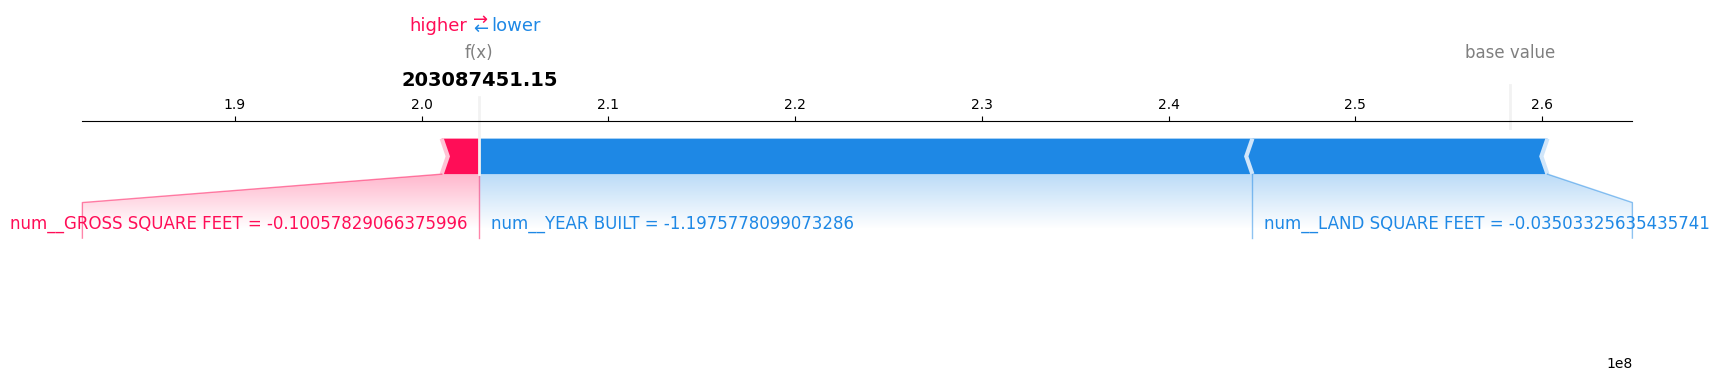

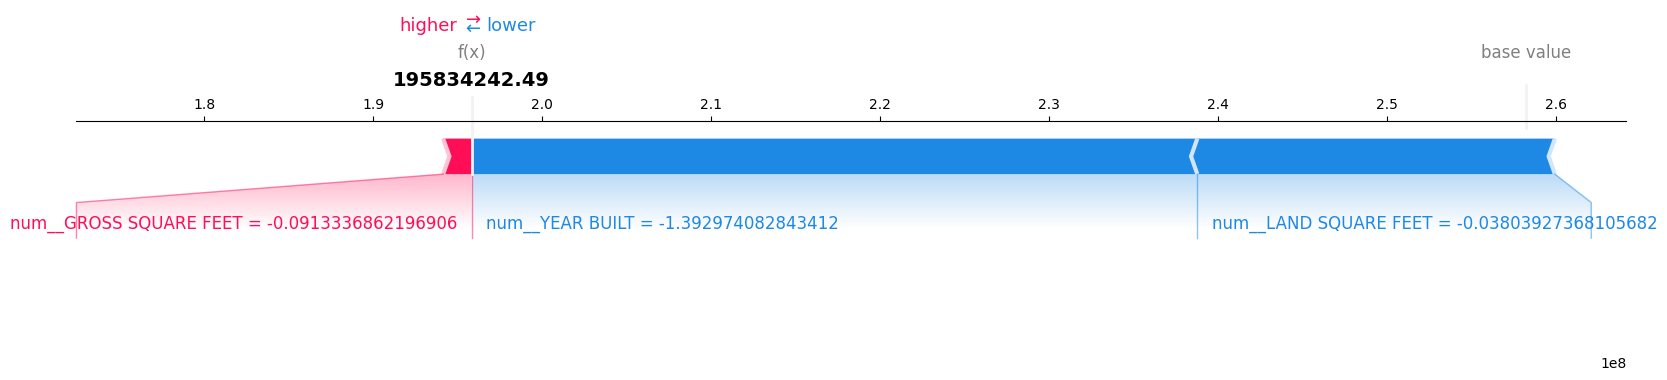

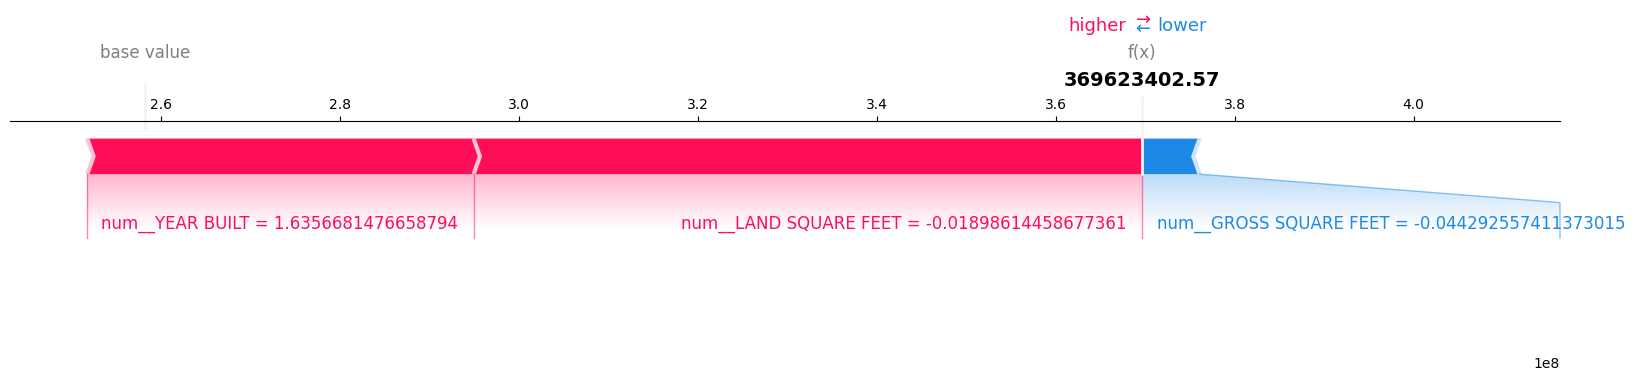

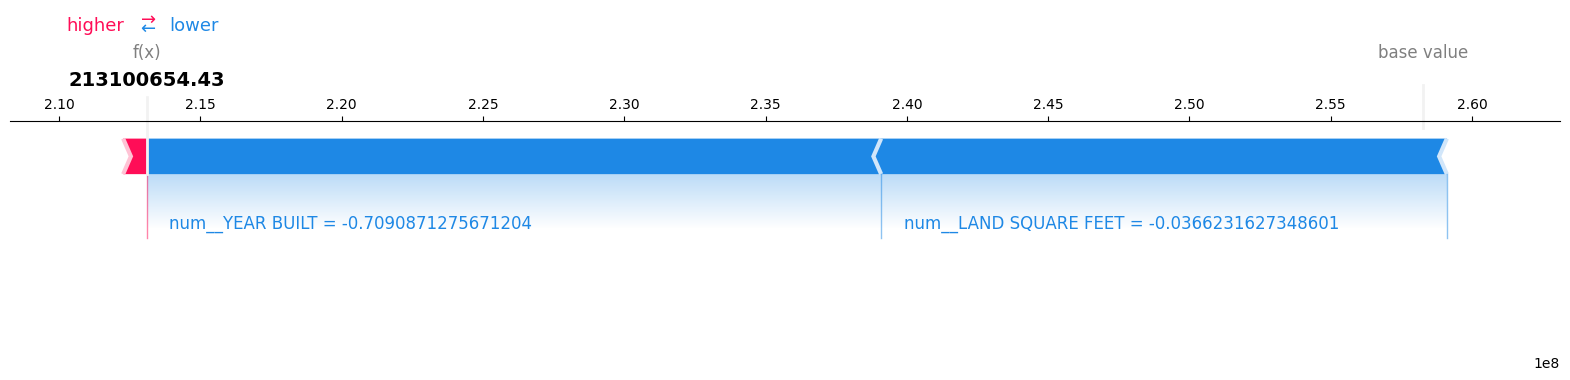

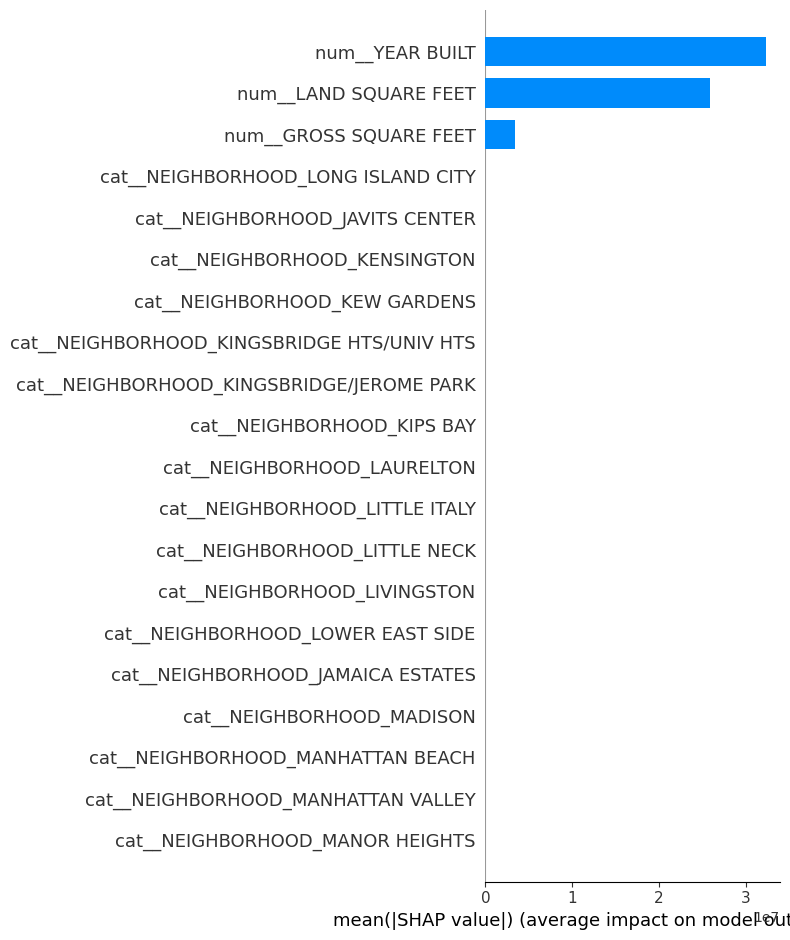

<Figure size 640x480 with 0 Axes>

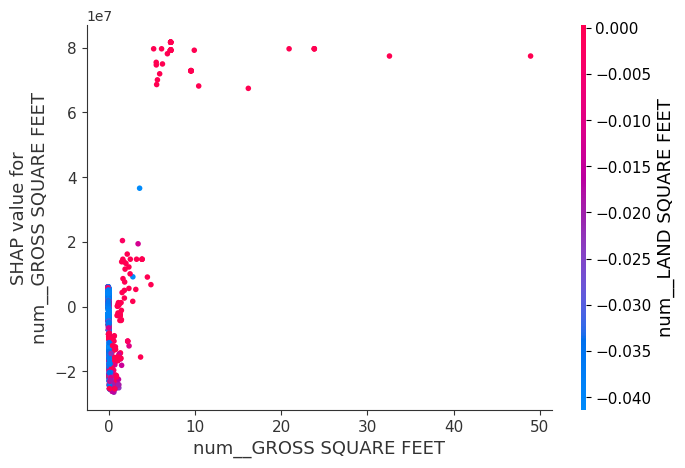

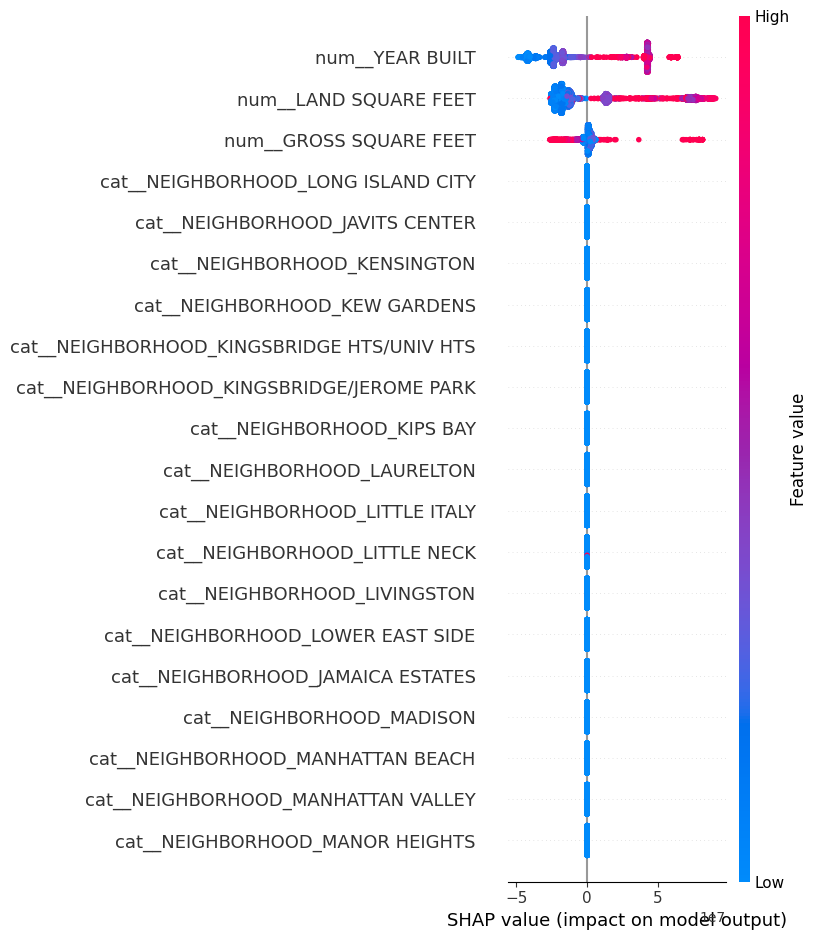

<Figure size 640x480 with 0 Axes>

In [12]:
import shap
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# Preprocess the test data to get the transformed features
X_test_processed = preprocessor.transform(X_test)

# Convert sparse matrix to dense format if necessary
if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Function to plot Partial Dependence Plot for a single feature
def plot_pdp_single_feature(model, X, feature_index):
    PartialDependenceDisplay.from_estimator(model, X, [feature_index])
    plt.show()

# Function to plot Partial Dependence Plot for feature interaction
def plot_pdp_interaction(model, X, feature_indices):
    PartialDependenceDisplay.from_estimator(model, X, feature_indices)
    plt.show()

# Find the indices of the desired features in the transformed data
gross_square_feet_index = np.where(feature_names == 'num__GROSS SQUARE FEET')[0][0]
land_square_feet_index = np.where(feature_names == 'num__LAND SQUARE FEET')[0][0]

# Plot PDP for a single feature (e.g., 'GROSS SQUARE FEET')
plot_pdp_single_feature(xgb_model, X_test_processed, gross_square_feet_index)

# Plot PDP for feature interaction (e.g., 'GROSS SQUARE FEET' and 'LAND SQUARE FEET')
plot_pdp_interaction(xgb_model, X_test_processed, [gross_square_feet_index, land_square_feet_index])

# Initialize SHAP explainer with processed data
explainer = shap.Explainer(xgb_model, X_test_processed)
shap_values = explainer(X_test_processed)

# Function to plot Shapley force plot for an individual prediction
def plot_shap_force_plot(shap_values, index):
    shap.force_plot(shap_values[index].base_values, shap_values[index].values, X_test_processed[index], feature_names=feature_names, matplotlib=True)
    plt.show()

# Plot Shapley force plot for a few individual predictions
plot_shap_force_plot(shap_values, 0)  # High prediction with low error
plot_shap_force_plot(shap_values, 1)  # Low prediction with low error
plot_shap_force_plot(shap_values, 2)  # High prediction with high error
plot_shap_force_plot(shap_values, 3)  # Low prediction with high error

# Save Shapley force plots as images
for i in range(4):
    shap.save_html(f'shap_force_plot_{i}.html', shap.force_plot(shap_values[i].base_values, shap_values[i].values, X_test_processed[i], feature_names=feature_names))

# Create and save other SHAP visualizations
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, plot_type='bar')
plt.savefig('shap_summary_plot_bar.png')

shap.dependence_plot('num__GROSS SQUARE FEET', shap_values.values, X_test_processed, feature_names=feature_names)
plt.savefig('shap_dependence_plot.png')

shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)
plt.savefig('shap_summary_plot.png')